In [1]:
from IPython import display
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras import Model
import time
import json
import sys
sys.path.append('/tf/code/preprocess/data_loader')
from data_loader import DataLoader

loader = DataLoader()
print(loader.length, loader.length_rois)

2023-06-12 18:28:39.354111: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Detectron2 not imported
3557 11003


In [2]:
batch_size = 4
num_channels = 1
num_classes = 8
image_size = 256
latent_dim = 128

In [3]:
dataset = tf.data.Dataset.from_generator(loader.classification_generator(output_size=image_size,
                                                                         classify_types=True,
                                                                         types_as="hot_encode"
                                                                        ),
                                         output_signature=(
                                             tf.TensorSpec(shape=(image_size,image_size,1), dtype=tf.float32, name="image"),
                                             tf.TensorSpec(shape=(num_classes), dtype=tf.float32, name="label")
                                         ),
                                        )

2023-06-07 07:55:44.828207: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-06-07 07:55:44.828278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: dd7f4d6c8361
2023-06-07 07:55:44.828285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: dd7f4d6c8361
2023-06-07 07:55:44.828428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-06-07 07:55:44.828458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 520.61.5


In [4]:
rescale_layer = tf.keras.layers.Rescaling(
    scale=1./127.5, offset=-1
)

dataset = dataset.map(lambda x, y: (rescale_layer(x), y))

In [5]:
photo = next(iter(dataset.take(1)))[0]
np.min(photo), np.max(photo)

2023-06-07 07:55:44.903945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


(-0.9843137, 1.0)

2023-06-07 07:55:44.976495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


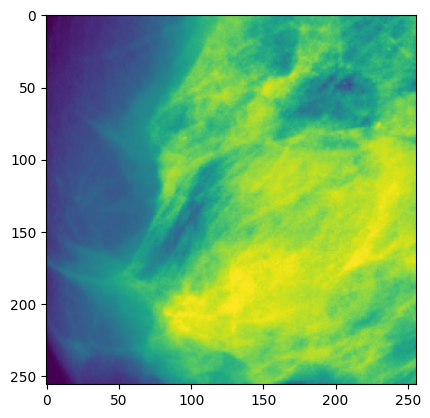

In [6]:
plt.imshow(next(iter(dataset.take(1)))[0])

In [7]:
train_ds = dataset.batch(batch_size)

In [8]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

136 9


In [9]:
# Create the discriminator.
discriminator = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer((image_size, image_size, discriminator_in_channels)),
        tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Conv2D(512, (5, 5), strides=(1, 1), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Conv2D(1024, (5, 5), strides=(1, 1), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

# Create the generator.
generator = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        tf.keras.layers.Dense(4 * 4 * generator_in_channels),
        tf.keras.layers.Reshape((4, 4, generator_in_channels)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(1024, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(32, (5, 5), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(1, (5, 5), padding="same", activation="tanh"),
    ],
    name="generator",
)
discriminator.summary()
generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      14464     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                     

                                                                 
 re_lu_7 (ReLU)              (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_13 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 1)       801       
                                                                 
Total params: 21,455,777
Trainable params: 21,451,217
Non-trainable params: 4,560
_________________________________________________________________


In [10]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [11]:
save_generator_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: save_generator(),
)

def save_generator():
    cond_gan.generator.save(f'./mammographies_gan_{datetime.now().strftime("%d%m%Y_%H%M%S")}')
    cond_gan.save(f'./mammographies_full_gan_{datetime.now().strftime("%d%m%Y_%H%M%S")}')
    display.clear_output()
    
                
json_log = open(f'loss_log_{datetime.now().strftime("%d%m%Y_%H%M%S")}.json', mode='wt', buffering=1)
json_logging_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: json_log.write(
        json.dumps({'epoch': epoch, 'g_loss': logs['g_loss'], 'd_loss': logs['d_loss']}) + '\n'),
    on_train_end=lambda logs: json_log.close()
)


In [12]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001, beta_1=0.5, beta_2=0.999, epsilon=1e-08),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5, beta_2=0.999, epsilon=1e-08),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

In [ ]:
history=cond_gan.fit(train_ds,
                     epochs=15,
                     callbacks=[json_logging_callback, save_generator_callback])

Epoch 1/15


2023-06-07 07:55:49.034189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/usr/local/lib/python3.8/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


    506/Unknown - 3794s 7s/step - g_loss: 0.7532 - d_loss: 0.6517

In [14]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

#model_name=f'./mammographies_gan_{datetime.now().strftime("%d%m%Y_%H%M%S")}'

#trained_gen.save(model_name)

2023-06-12 18:28:51.811063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-12 18:28:51.815474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-12 18:28:51.815666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-06-12 18:28:54.412653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-12 18:28:55.298637: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-12 18:28:55.353346: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 2s 2s/step


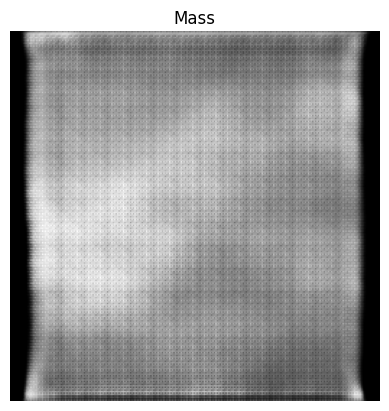

1/1 [==============================] - 0s 16ms/step


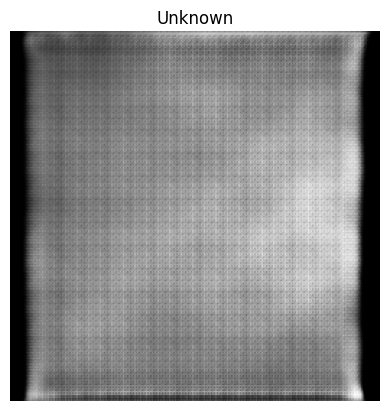

1/1 [==============================] - 0s 15ms/step


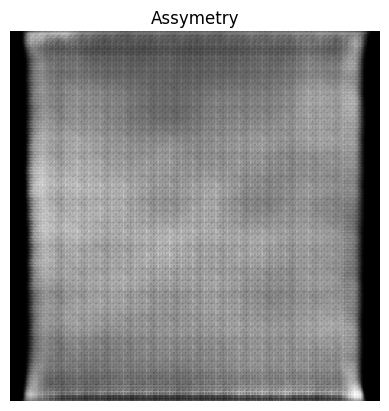

1/1 [==============================] - 0s 16ms/step


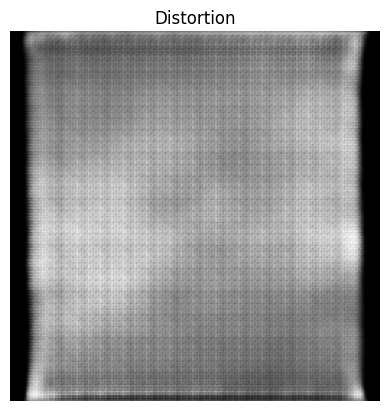

1/1 [==============================] - 0s 16ms/step


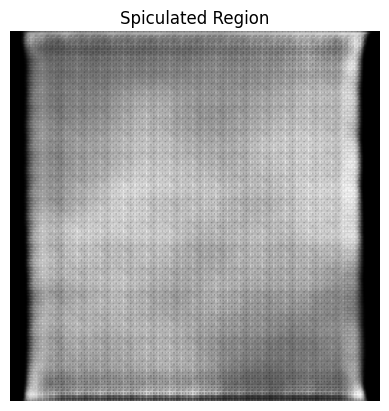

1/1 [==============================] - 0s 16ms/step


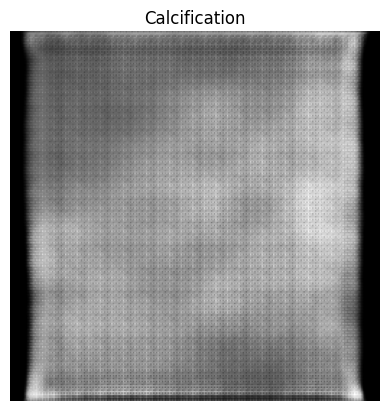

1/1 [==============================] - 0s 14ms/step


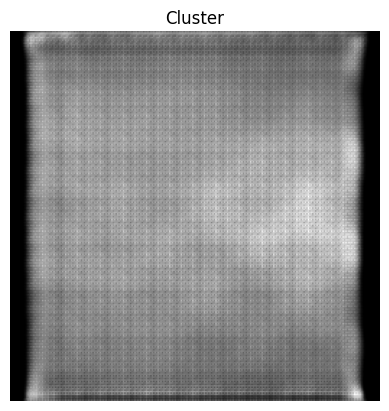

In [3]:
trained_gen = tf.keras.models.load_model("mammographies_gan_07062023_163555")
trained_gen.compile()

def generate_sample(label_ex):
    interpolation_noise = tf.random.normal(shape=(1, latent_dim))
    label = tf.keras.utils.to_categorical([label_ex], num_classes)
    label = tf.cast(label, tf.float32)
    noise_and_label = tf.concat([interpolation_noise, label], 1)
    fake = trained_gen.predict(noise_and_label)
    fake += 1.0
    fake *= 127.5
    return fake.astype(np.uint8)

for key in loader.type2int.keys():
    plt.title(key)
    image=generate_sample(loader.type2int[key])[0]
    plt.imshow(image, cmap="gray")
    plt.axis('off')
    plt.show()

In [5]:
with open("loss_log_07062023_102838.json", "r") as json_file:
    data = json.load(json_file)

## Generate data with generator of epoch 17

2023-06-12 18:28:51.811063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-12 18:28:51.815474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-12 18:28:51.815666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-06-12 18:28:54.412653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-12 18:28:55.298637: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-12 18:28:55.353346: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 2s 2s/step


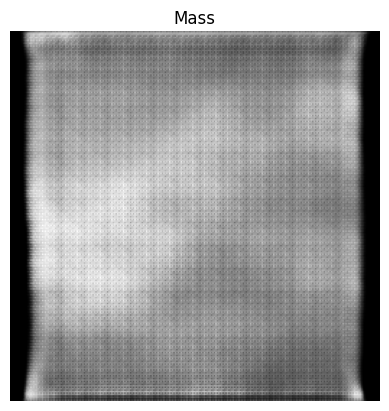

1/1 [==============================] - 0s 16ms/step


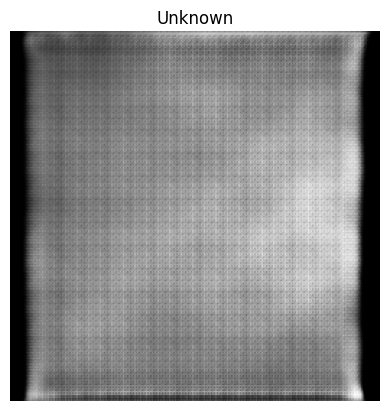

1/1 [==============================] - 0s 15ms/step


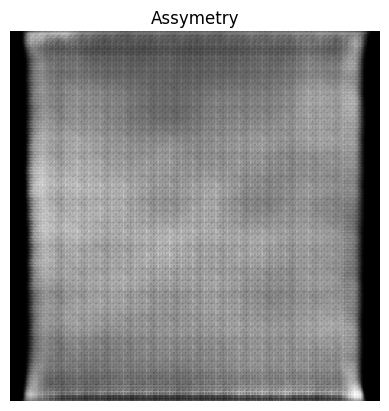

1/1 [==============================] - 0s 16ms/step


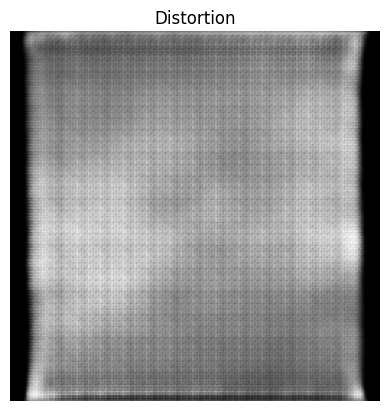

1/1 [==============================] - 0s 16ms/step


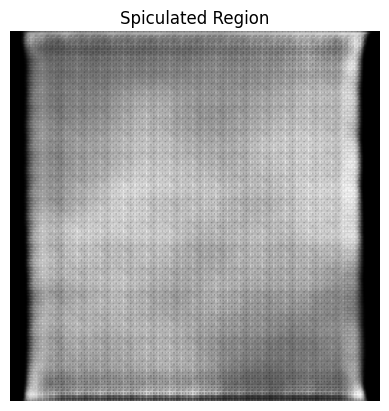

1/1 [==============================] - 0s 16ms/step


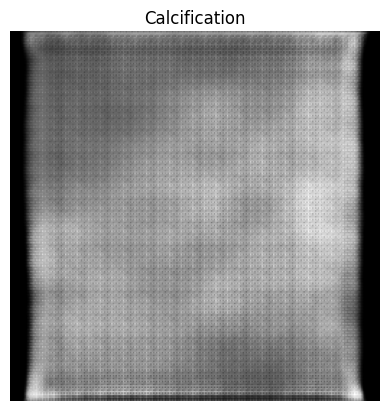

1/1 [==============================] - 0s 14ms/step


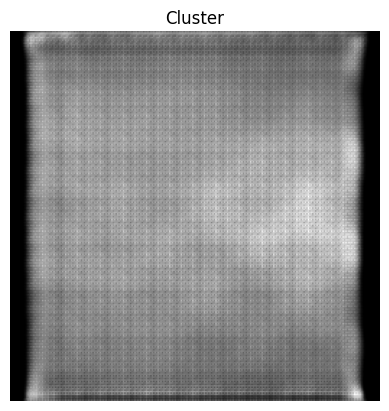

In [3]:
trained_gen = tf.keras.models.load_model("mammographies_gan_07062023_163555")
trained_gen.compile()

def generate_sample(label_ex):
    interpolation_noise = tf.random.normal(shape=(1, latent_dim))
    label = tf.keras.utils.to_categorical([label_ex], num_classes)
    label = tf.cast(label, tf.float32)
    noise_and_label = tf.concat([interpolation_noise, label], 1)
    fake = trained_gen.predict(noise_and_label)
    #print(np.max(fake), np.min(fake))
    #fake = (fake - np.min(fake)) / (np.max(fake) - np.min(fake)) *255
    fake += 1.0
    fake *= 127.5
    #plt.hist(fake.ravel())
    #plt.show()
    #print(np.min(fake), np.max(fake))
    return fake.astype(np.uint8)

for key in loader.type2int.keys():
    plt.title(key)
    image=generate_sample(loader.type2int[key])[0]
    plt.imshow(image, cmap="gray")
    plt.axis('off')
    plt.show()

## Generate data with generator of last epoch

1/1 [==============================] - 0s 178ms/step


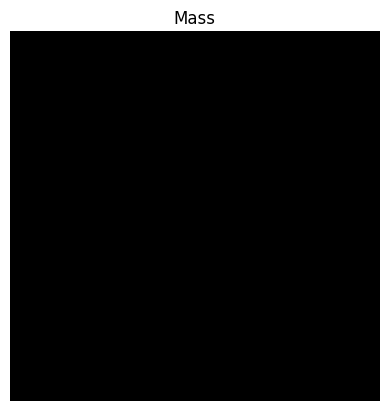

1/1 [==============================] - 0s 15ms/step


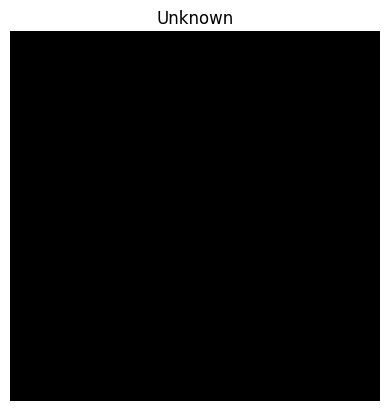

1/1 [==============================] - 0s 15ms/step


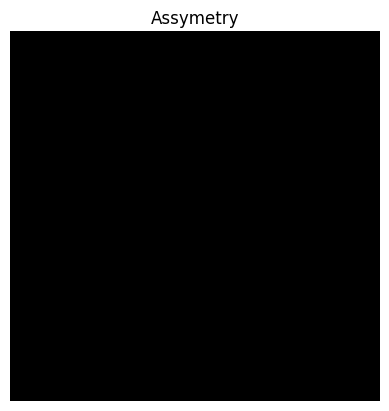

1/1 [==============================] - 0s 16ms/step


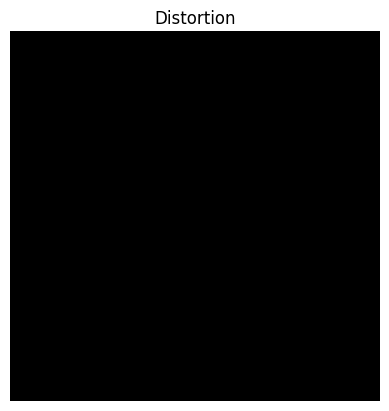

1/1 [==============================] - 0s 16ms/step


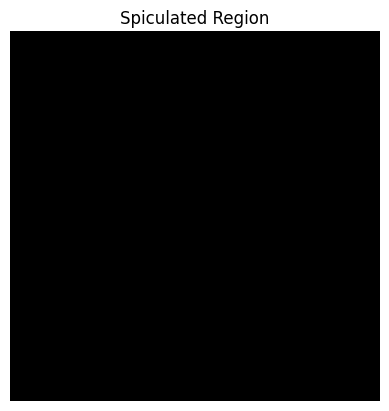

1/1 [==============================] - 0s 14ms/step


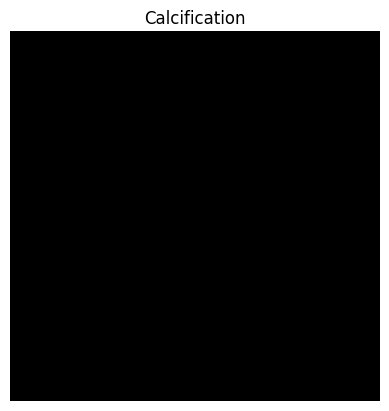

1/1 [==============================] - 0s 15ms/step


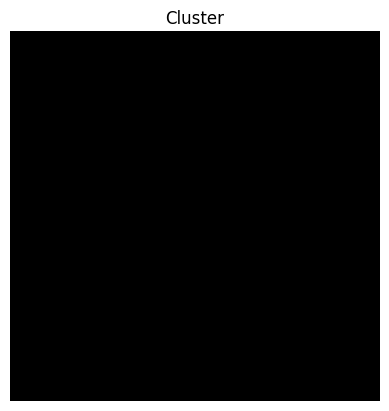

In [4]:
trained_gen = tf.keras.models.load_model("mammographies_gan_07062023_222020")
trained_gen.compile()

def generate_sample(label_ex):
    interpolation_noise = tf.random.normal(shape=(1, latent_dim))
    label = tf.keras.utils.to_categorical([label_ex], num_classes)
    label = tf.cast(label, tf.float32)
    noise_and_label = tf.concat([interpolation_noise, label], 1)
    fake = trained_gen.predict(noise_and_label)
    #print(np.max(fake), np.min(fake))
    #fake = (fake - np.min(fake)) / (np.max(fake) - np.min(fake)) *255
    fake += 1.0
    fake *= 127.5
    #plt.hist(fake.ravel())
    #plt.show()
    #print(np.min(fake), np.max(fake))
    return fake.astype(np.uint8)

for key in loader.type2int.keys():
    plt.title(key)
    image=generate_sample(loader.type2int[key])[0]
    plt.imshow(image, cmap="gray")
    plt.axis('off')
    plt.show()

## Training loss

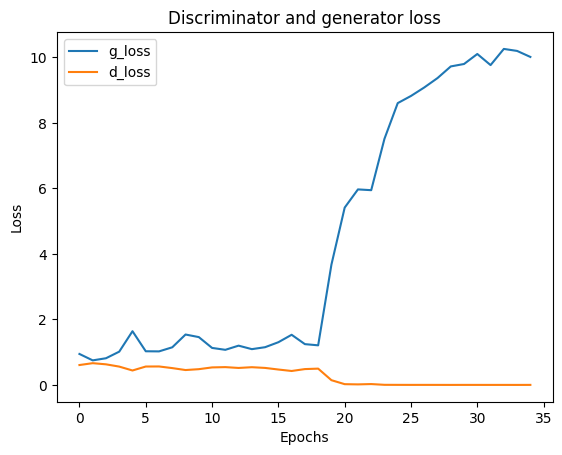

In [16]:
g_loss = list(map(lambda x: x["g_loss"] ,data))
d_loss = list(map(lambda x: x["d_loss"] ,data))
plt.plot(g_loss, label="g_loss")
plt.plot(d_loss, label="d_loss")
plt.title("Discriminator and generator loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()